In [396]:
import numpy as np
import pandas as pd
import h5py
import time

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import cooler

cooler_path = '/Volumes/FFRITZ/4DN/data/rao/Rao2014-GM12878-MboI-allreps-filtered.5kb.cool'
loops_path = '/Volumes/FFRITZ/4DN/data/rao/GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt'

loops = [
    ('chr2', 135215000, 135220000, 'chr2', 135655000, 135660000),
    ('chr2', 135740000, 135750000, 'chr2', 137140000, 137150000),
    ('chr2', 135760000, 135765000, 'chr2', 136465000, 136470000),
    ('chr2', 136230000, 136235000, 'chr2', 136465000, 136470000),
    ('chr2', 136670000, 136675000, 'chr2', 136885000, 136890000),
    ('chr2', 136670000, 136675000, 'chr2', 137140000, 137145000),
    ('chr2', 136890000, 136895000, 'chr2', 137080000, 137085000),
    ('chr2', 136890000, 136895000, 'chr2', 137135000, 137140000),
    ('chr3', 49575000, 49580000, 'chr3', 49710000, 49715000),
    ('chr10', 100225000, 100230000, 'chr10', 100420000, 100425000),
]

test_loops_chr_2 = pd.DataFrame([{
        'x1': 135215000,
        'x2': 135220000,
        'y1': 135655000,
        'y2': 135660000
    }, {
        'x1': 135740000,
        'x2': 135750000,
        'y1': 137140000,
        'y2': 137150000
    }, {
        'x1': 135760000,
        'x2': 135765000,
        'y1': 136465000,
        'y2': 136470000
    }, {
        'x1': 136230000,
        'x2': 136235000,
        'y1': 136465000,
        'y2': 136470000
    }
], index=['2', '2', '2', '2'])

test_loops_chr_22 = pd.DataFrame([{
        'x1': 17395000,
        'x2': 17400000,
        'y1': 17535000,
        'y2': 17540000
    }, {
        'x1': 17400000,
        'x2': 17410000,
        'y1': 17980000,
        'y2': 17990000
    }, {
        'x1': 17650000,
        'x2': 17655000,
        'y1': 17980000,
        'y2': 17985000
    }, {
        'x1': 17690000,
        'x2': 17700000,
        'y1': 18250000,
        'y2': 18260000
    }
], index=['22', '22', '22', '22'])

loops = pd.DataFrame.from_csv(loops_path, sep='\t', header=0)

CHROM_SIZES = cooler.read_chromsizes('/Volumes/FFRITZ/4DN/data/hg19-chrom-info.txt')
CHROMS = list(CHROM_SIZES.keys())
CHROM_IDS = dict(zip(CHROMS, range(len(CHROMS))))
CUM_LEN = np.r_[0, np.cumsum(CHROM_SIZES)]

In [356]:
loop2AbsChoord(('chr22', 17395000, 17400000, 'chr22', 17535000, 17540000))

(2847123720, 2847128720, 2847263720, 2847268720)

In [2]:
def chrCoord2AbsChoord(chr, x, y):
    offset = CUM_LEN[CHROM_IDS[chr]]
    
    return (offset + x, offset + y)

In [3]:
def loop2AbsChoord(tuple):
    return chrCoord2AbsChoord(*tuple[0:3]) + chrCoord2AbsChoord(*tuple[3:6])

In [8]:
def absCoord2bin(c, pos):
    try:
        chr_id = np.flatnonzero(CUM_LEN > pos)[0] - 1
    except IndexError:
        return c.info['nbins']
    
    chrom = CHROMS[chr_id]
    relPos = pos - CUM_LEN[chr_id]
    
    return c.offset((chrom, relPos, CHROM_SIZES[chrom]))

In [410]:
def get_loop_tile(c, start_pos1, end_pos1, start_pos2, end_pos2, padding=10, normalize=True, balanced=True, max_dim=22):
    # absCoord2bin(...) returns the inclusive bin ID but in the python work the end position is always exclusive
    start_bin_1 = max(absCoord2bin(c, start_pos1) - padding, 0)
    start_bin_2 = max(absCoord2bin(c, start_pos2) - padding, 0)
    end_bin_1 = absCoord2bin(c, end_pos1) + 1 + padding
    end_bin_2 = absCoord2bin(c, end_pos2) + 1 + padding

    pixels = c.matrix(as_pixels=True, max_chunk=np.inf, balance=True)[start_bin_1:end_bin_1, start_bin_2:end_bin_2]
    

    pixels['id_1'] = pixels['bin1_id'] - start_bin_1
    pixels['id_2'] = pixels['bin2_id'] - start_bin_2

    dim = min(abs(start_bin_1 - end_bin_1), abs(start_bin_2 - end_bin_2))

    out = np.zeros(dim**2, dtype=np.float)
    
    accessor = 'count'
    
    if balanced:
        accessor = 'balanced'

    for index, row in pixels.iterrows():
        out[row['id_1'].astype(np.uint32) * dim + row['id_2'].astype(np.uint32)] = np.nan_to_num(row[accessor])

    if normalize:
        out = out / np.max(out)
        
    return out.reshape(dim, dim)[:max_dim, :max_dim]

In [417]:
def get_intra_loops_by_chr(chr, max=-1, balanced=True):
    with h5py.File(f_path, 'r') as f:
        c = cooler.Cooler(f)
        
        chr = str(chr)
        s_chr = 'chr%s' % chr

        chr_loops = loops[loops['chr2'] == chr].loc[chr]

        mat_snippets = np.zeros((len(chr_loops), 22, 22))

        k = 0
        for index, loop in chr_loops.iterrows():
            t0 = time.time()
            
            abs_coords = loop2AbsChoord((s_chr, loop['x1'], loop['x2'], s_chr, loop['y1'], loop['y2']))
            mat_snippets[k] = get_loop_tile(c, *abs_coords, balanced=balanced)
    
            print "%d. took %f sec" % (k, (time.time() - t0))
            
            if max > 0 and k >= max:
                break
            k += 1
    
    return mat_snippets

In [418]:
t0 = time.time()
loop_imgs_chr_22 = get_intra_loops_by_chr(22)
print time.time() - t0, 'sec'

0. took 0.172275 sec
1. took 0.149170 sec
2. took 0.179210 sec
3. took 0.183171 sec
4. took 0.172094 sec
5. took 0.137325 sec
6. took 0.146693 sec
7. took 0.182608 sec
8. took 0.182189 sec
9. took 0.162428 sec
10. took 0.157948 sec
11. took 0.179437 sec
12. took 0.177533 sec
13. took 0.166281 sec
14. took 0.173804 sec
15. took 0.148587 sec
16. took 0.171806 sec
17. took 0.150027 sec
18. took 0.144950 sec
19. took 0.153865 sec
20. took 0.154420 sec
21. took 0.171508 sec
22. took 0.145582 sec
23. took 0.159116 sec
24. took 0.157864 sec
25. took 0.109732 sec
26. took 0.158504 sec
27. took 0.167509 sec
28. took 0.151443 sec
29. took 0.158517 sec
30. took 0.125660 sec
31. took 0.170930 sec
32. took 0.186989 sec
33. took 0.125773 sec
34. took 0.170760 sec
35. took 0.119210 sec
36. took 0.157653 sec
37. took 0.157230 sec
38. took 0.170232 sec
39. took 0.165907 sec
40. took 0.160473 sec
41. took 0.171191 sec
42. took 0.154297 sec
43. took 0.165449 sec
44. took 0.150957 sec
45. took 0.178409 se

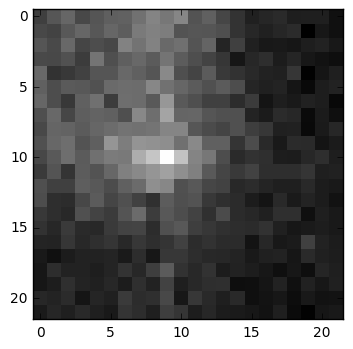

In [419]:
imshow(loop_imgs_chr_22[150], 'gray', interpolation='none')

In [420]:
import json
with open('loop_imgs_chr_22.dyjson', 'w') as f:
    json.dump(loop_imgs_chr_22.tolist(), f)